In [126]:
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
from sklearn.preprocessing import LabelEncoder

def load_data(file_path):
    """
    Load the enriched data with weather and additional features.
    """
    df = pd.read_csv(file_path)

    # 确保 'Arrival Time' 存在且可以提取小时
    if 'Arrival Time' in df.columns:
        df['arrival_hour'] = pd.to_datetime(
            df['Arrival Time'], format='%H:%M:%S', errors='coerce'
        ).dt.hour
        df = df.dropna(subset=['arrival_hour'])  # 删除解析失败的行
    else:
        raise KeyError("'Arrival Time' column is missing in the dataset.")

    # 填充缺失值
    df = df.ffill().bfill()

    # 将非数值列转换为数值
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    for col in non_numeric_columns:
        if col not in ['Weather', 'arrival_minutes_after_noon']:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col].astype(str))

    return df





In [128]:
def decode_weather(df):
    weather_columns = [col for col in df.columns if col.startswith('Weather_')]

    if not weather_columns:
        raise KeyError("No 'Weather_' columns found in the dataset.")

    df['Weather'] = df[weather_columns].idxmax(axis=1).str.replace('Weather_', '')

    return df


In [129]:
def get_features_and_target(df):
    y = df['arrival_minutes_after_noon']
    X = df.drop(columns=['arrival_minutes_after_noon'])
    return X, y

In [130]:
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, c='red', label='Predictions', alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()],
             color='blue', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [131]:
def plot_daily_arrival_distribution(df, model_name="Model"):
    actual_avg = df.groupby('arrival_hour')['arrival_minutes_after_noon'].mean()
    predicted_avg = df.groupby('arrival_hour')['predicted_minutes_after_noon'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(actual_avg.index, actual_avg, label="Actual", marker='o', linestyle='-', color='blue')
    plt.plot(predicted_avg.index, predicted_avg, label="Predicted", marker='x', linestyle='--', color='red')
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Arrival Time (minutes after noon)")
    plt.title(f"Daily Arrival Time Distribution: Actual vs Predicted ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_weather_impact_boxplot(df):
    if 'Weather' not in df.columns or 'arrival_minutes_after_noon' not in df.columns:
        raise KeyError("The dataset must contain 'Weather' and 'arrival_minutes_after_noon' columns.")

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df,
        x='Weather',
        y='arrival_minutes_after_noon',
        palette="Set3",  
        hue=None,  
        dodge=False  
    )
    plt.title("Impact of Weather on Arrival Time", fontsize=16)
    plt.xlabel("Weather Condition", fontsize=14)
    plt.ylabel("Arrival Time (Minutes After Noon)", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [151]:
def add_weekday_weekend(df):

    if 'Date' not in df.columns:
        raise KeyError("'Date' column is missing in the dataset.")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 确保日期列格式正确
    df['is_weekend'] = df['Date'].dt.weekday >= 5  # 周六日为 True
    df['day_type'] = df['is_weekend'].apply(lambda x: 'Weekend' if x else 'Weekday')
    return df

In [152]:
def plot_weekday_weekend_comparison(df):

    if 'arrival_hour' not in df.columns or 'day_type' not in df.columns:
        raise KeyError("Dataset must contain 'arrival_hour' and 'day_type' columns.")

    grouped = df.groupby(['arrival_hour', 'day_type'])['arrival_minutes_after_noon'].mean().unstack()

    grouped.plot(kind='bar', figsize=(12, 6), width=0.8, alpha=0.75)
    plt.title("Weekday vs Weekend Arrival Time Comparison", fontsize=16)
    plt.xlabel("Hour of Day", fontsize=14)
    plt.ylabel("Average Arrival Time (minutes after noon)", fontsize=14)
    plt.legend(title="Day Type", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

In [153]:
def train_random_forest(X, y):

    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for RandomForest:", grid_search.best_params_)
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"RandomForest MAE on entire set: {mae:.2f}")
    return best_model, y_pred, mae

In [154]:
def train_xgboost(X, y):

    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.1, 0.05],
        'model__gamma': [0, 1]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='mae'))
    ])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for XGBoost:", grid_search.best_params_)
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"XGBoost MAE on entire set: {mae:.2f}")
    return best_model, y_pred, mae

Training RandomForest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for RandomForest: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RandomForest MAE on entire set: 0.18


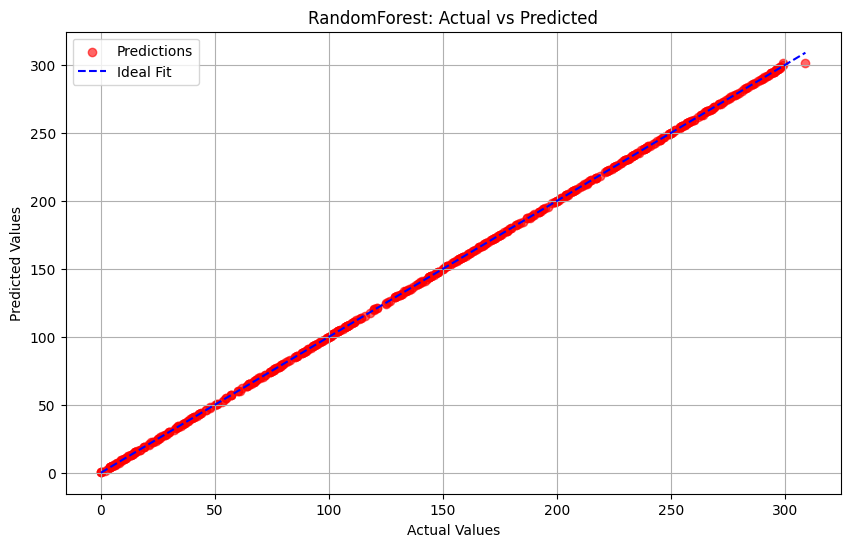

Training completed.


In [156]:
if __name__ == "__main__":
    model_type = 'rf' 
    file_path = 'bus_arrival_schedule_with_weather.csv'

    df = load_data(file_path)
    X, y = get_features_and_target(df)
    df = add_weekday_weekend(df)

    if model_type.lower() == 'rf':
        print("Training RandomForest...")
        model, y_pred, mae = train_random_forest(X, y)
        df['predicted_minutes_after_noon'] = y_pred
        plot_actual_vs_predicted(y, y_pred, title="RandomForest: Actual vs Predicted")
    elif model_type.lower() == 'xgb':
        print("Training XGBoost...")
        model, y_pred, mae = train_xgboost(X, y)
        df['predicted_minutes_after_noon'] = y_pred
        plot_actual_vs_predicted(y, y_pred, title="XGBoost: Actual vs Predicted")
        plot_daily_arrival_distribution(df, model_name="XGBoost")
    else:
        print("Invalid model selected. Choose 'rf' or 'xgb'.")
        exit(1)

    print("Training completed.")

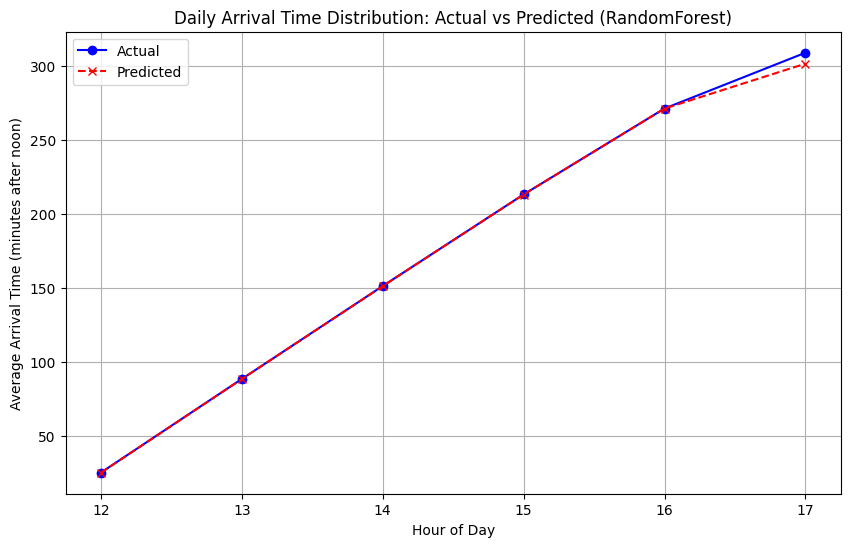

In [157]:
plot_daily_arrival_distribution(df, model_name="RandomForest")

C:\Users\83340\AppData\Local\Temp\ipykernel_46728\2939741628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


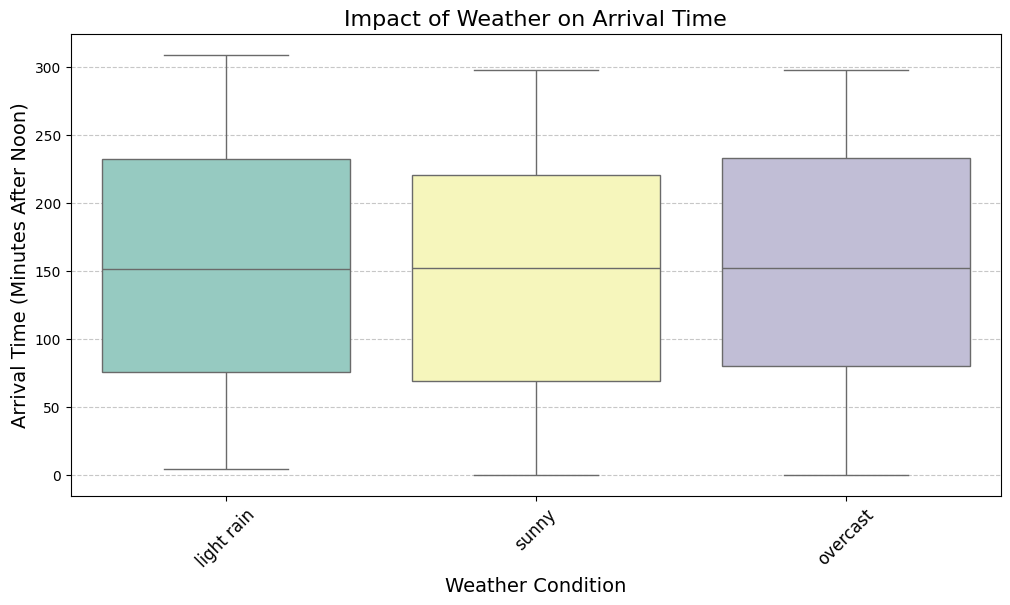

In [165]:
plot_weather_impact_boxplot(df)

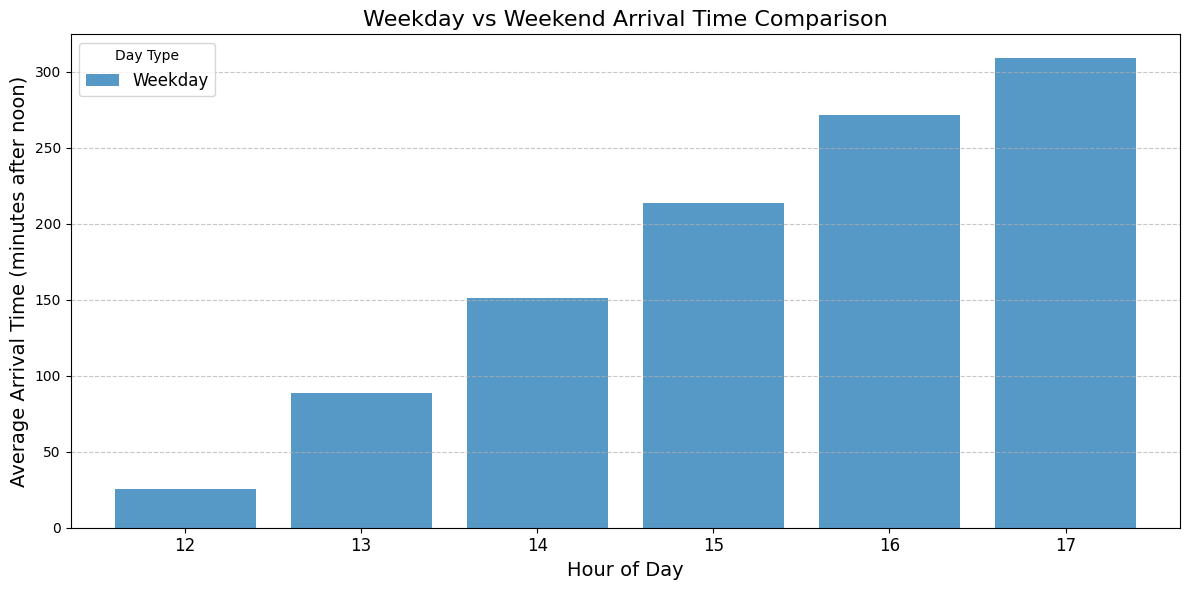

In [164]:
plot_weekday_weekend_comparison(df)